In [1]:
%matplotlib inline


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting this notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios looks as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [2]:
# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



torch.Size([4, 3, 224, 224])
torch.Size([3, 228, 906])


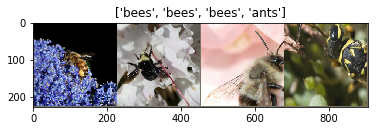

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))
print(inputs.size())
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.size())

imshow(out, title=[dset_classes[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving (deep copying) the best model

In the following, parameter ``lr_scheduler(optimizer, epoch)``
is a function  which modifies ``optimizer`` so that the learning
rate is changed according to desired schedule.



In [5]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

Learning rate scheduler
^^^^^^^^^^^^^^^^^^^^^^^
Let's create our learning rate scheduler. We will exponentially
decrease the learning rate once every few epochs.



In [6]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [10]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/Sam/.torch/models/resnet18-5c106cde.pth
100.0%


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.1265 Acc: 0.7213
val Loss: 0.1100 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.1326 Acc: 0.7910
val Loss: 0.0858 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.1098 Acc: 0.8115
val Loss: 0.0792 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.1158 Acc: 0.7951
val Loss: 0.0547 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.0861 Acc: 0.8648
val Loss: 0.0694 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.1037 Acc: 0.8074
val Loss: 0.0834 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.1043 Acc: 0.8402
val Loss: 0.0740 Acc: 0.8954

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0731 Acc: 0.8975
val Loss: 0.0672 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.0931 Acc: 0.8443
val Loss: 0.0682 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.0760 Acc: 0.8566
val Loss: 0.0678 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.0507 Acc: 0.9303
val Loss: 0.0614 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0792 Acc: 

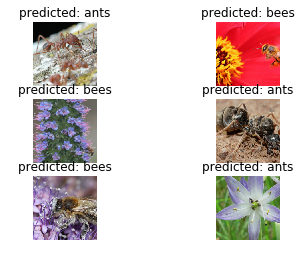

In [13]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.1405 Acc: 0.6926
val Loss: 0.0927 Acc: 0.7974

Epoch 1/24
----------
train Loss: 0.1424 Acc: 0.7295
val Loss: 0.0533 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.1193 Acc: 0.7787
val Loss: 0.0577 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.0993 Acc: 0.8279
val Loss: 0.0461 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.1995 Acc: 0.7090
val Loss: 0.0518 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.1108 Acc: 0.8115
val Loss: 0.0474 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.1094 Acc: 0.7787
val Loss: 0.0514 Acc: 0.9412

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0730 Acc: 0.8893
val Loss: 0.0494 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.0833 Acc: 0.8484
val Loss: 0.0467 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.0781 Acc: 0.8648
val Loss: 0.0511 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.0790 Acc: 0.8566
val Loss: 0.0545 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.0811 Acc: 

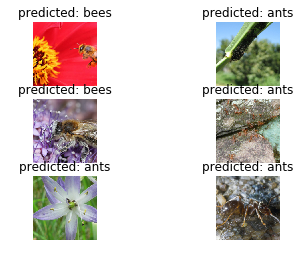

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()